# 03_Car Price Prediction - Data Cleaning & Preprocessing

**Goal:** Prepare the raw car listing data for Machine Learning. 
**Target Variable:** `price` (I want to predict the price based on its features and Attributes).

**Steps covered in this notebook:**
1. Load Data
2. Data Cleaning (Missing Values, Data Types, Junk text, cleaning title/model)
3. Feature Engineering (Creating new useful columns)
4. Encoding Data
5. Export for Model Training


**Imports libraries**

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
print("Imported are loaded")

Imported are loaded


**Reading data from csv to Data Frame**

In [2]:
# Defining Path to Read Data
BASE_DIR = os.path.dirname(os.getcwd())
DB_NAME = "data/ebay_cars.db"

DB = os.path.join(BASE_DIR, DB_NAME)
# Connect to the Database

conn = sqlite3.connect(DB)

# Load data directly from SQL
print("Reading data from SQLite Database...")
df = pd.read_sql("SELECT * FROM listings", conn)
conn.close()

print(f"Dataset Shape: {df.shape}")
df.head()

Reading data from SQLite Database...
Dataset Shape: (4628, 12)


,id,title,price,year,mileage,brand,condition,bids,seller_score,reviews_count,link_type,status
0,1,2004 BMW 5-Series 525i,1750.0,2004,171100,BMW,Pre-Owned,45.0,99%,10300,Auction,Active
1,2,2007 Honda Accord,660.0,2007,256860,Honda,Pre-Owned,26.0,99%,10300,Auction,Active
2,3,2019 Nissan Altima 2.5 Platinum AWD clean carf...,5100.0,2019,16550,Nissan,Great Value Look,60.0,100%,2300,Buy It Now,Active
3,4,New Listing2016 Q50 3.0T PREMIUM NAV BK/CAM RO...,11995.0,2016,93981,Infiniti,Pre-Owned,NaN,100%,888,None,Active
4,5,2013 Toyota Avalon XLE Premium 4dr Sedan,7700.0,2013,57449,Toyota,AmeriCarsUSA Hollywood 305-331-5208,25.0,96%,1500,Buy It Now,Active


**Setting Limitations**
- I saw this during BI reports, there are few cars beyond these limits and then some of them are vintage cars. The cars beyond these limitations were not helping in Model prediction.
- I have tested with different number and these are the best fit.

In [3]:
# 1. Remove Price Outliers
# Rule: Price must be between $500 and $100,000
# (Cars under $500 are usually just parts or down payments)
df = df[(df['price'] > 500) & (df['price'] <= 100000)]

# 2. Remove Mileage Outliers
# Rule: Mileage must be realistic (e.g., < 200,000 miles)
df = df[df['mileage'] <= 200000]

# 3. Year Validation
df = df[(df['year'] > 1999) & (df['year'] <= 2025)]

print(f"Data shape after outlier removal: {df.shape}")

Data shape after outlier removal: (3784, 12)


**Cleaning and Conversion**
- Converted feature column names to lower case.
- Removed brand from model as I already have a separate column for Brand.
- Removed junk text from title to make it readable for better comparison, otherwise the model would treat each value as unique, impacting accuracy.

In [4]:
# 1. Cleaning Function
def get_clean_model_name(row):
    # Convert to lowercase strings
    text = str(row['title']).lower()
    brand = str(row['brand']).lower()
    
    # A. Remove the Brand Name (e.g., delete "bmw" from "bmw 328i")
    text = text.replace(brand, '')
    
    # B. Remove "New Listing" tag
    text = text.replace('new listing', '')
    
    # C. Remove Years & K miles(Finds 19xx|20xx|xKkx and deletes them)
    text = re.sub(r'\b(19|20)\d{2}\b', '', text)
    text = re.sub(r'\b\d+[kK]\b', '', text)

    # D. Remove Common Junk Words (Trims, Body Styles)
    # Added as possible as i could, but it did made a difference
    junk_words = [
        'sedan', 'coupe', 'suv', 'truck', 'van', 'minivan', 'convertible', 'lthr', 'roof','orig', 'nice','we','financetradeship'
        'hatchback', 'wagon', 'pickup', '4d', '2d', '4dr', '2dr', 'repairable','nav', 'htd' ,'sts','ownerclean', 'carfax','ship'
        'awd', '4wd', 'rwd', 'fwd', 'auto', 'manual', 'miles', 'mile', 'owner','fresh','trade','rebuildable','financing','delivery'
        'door', 'doors', 'sport', 'limited', 'premium', 'edition', 'se', 'le', 'xle', 'gt','pics','must','sell','nationwide',
        'free','new','other','is is','is','clean','low','loaded'
    ]
    
    # Create a regex pattern to remove these words safely (whole words only)
    # This prevents removing "se" from "senna" or "le" from "lexus"
    pattern = r'\b(' + '|'.join(junk_words) + r')\b'
    text = re.sub(pattern, '', text)
        
    # E. Cleanup: Remove special characters and extra spaces
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove punctuation (-, /, etc)
    text = re.sub(r'\s+', ' ', text).strip() # Collapse multiple spaces to one
    
    return text

# 2. Apply it to DataFrame
print(" Cleaning Titles...")
df['clean_model'] = df.apply(get_clean_model_name, axis=1)


print(f" Cleanup Complete.")

 Cleaning Titles...
 Cleanup Complete.


### Verify Null clean_model after aggresive cleaning

In [5]:
# TO verify if I deleted any title entirely
empty_titles = (df['clean_model'] == "") | (df['clean_model'].isna())
count = empty_titles.sum()
print(f"The count of empty titles {count}")

The count of empty titles 4


**Due to Aggressive Cleaning some of the rows in clean model were completely removed.**
- Verified the empty cells
- Inserted the values "Year" + "brand" to make it a proper listing
- Encoded model and brand for modelling

In [6]:
# FIND THE GHOSTS 
# Look for rows where the model name became empty string ""
empty_mask = (df['clean_model'] == "") | (df['clean_model'].isna())
ghost_count = empty_mask.sum()

print(f"Found {ghost_count} cars with empty model names.")

if ghost_count > 0:
  df.loc[empty_mask, 'clean_model'] = df.loc[empty_mask].apply(
    lambda row: f"{int(row['year'])} {str(row['brand']).lower()}", 
    axis=1)
  print("Model Values has been updated !")
    
    
# CRITICAL: UPDATE THE ENCODING & SAVE
# Since I changed text, I must update the numbers again
df['model_encoded'] = df['clean_model'].astype('category').cat.codes
df['brand_encoded'] = df['brand'].astype('category').cat.codes

print("Values are encoded as well")


Found 4 cars with empty model names.
Model Values has been updated !
Values are encoded as well


**Car Condition**
**To differenciate into 2 categories and cleaning the rest of them
- New
- Used

In [7]:
# 1. Define a cleaner function to group the values into 2 buckets
def clean_condition(x):
    s = str(x).lower()
    
    # Bucket 1: NEW
    # I look for "brand new" or just "new" if it appears alone
    if 'brand new' in s:
        return 1  # 1 = New
    
    # Bucket 2: USED
    # "Pre-Owned", Dealer Names, Mileage numbers, "M5", etc. all go here.
    return 0  # 0 = Used

# 2. Apply the cleaning
df['is_new'] = df['condition'].apply(clean_condition)

# 3. Verify the result
print("--- Transformation Results ---")
print(df['is_new'].value_counts())


--- Transformation Results ---
is_new
0    3745
1      39
Name: count, dtype: int64


**Only keeping the Used ones because New listings are not enough for Model Training**

In [8]:
# --- STEP 1: DROP ROWS (Remove New Cars) ---
print(f"Total Row Count: {len(df)}")

# Keep only rows where is_new is 0 (Used)
df = df[df['is_new'] == 0].copy()

print(f"Row Count after dropping New cars: {len(df)}")


# Drop rows with missing Brand
# Logic: I can't predict the price if I don't know the brand (only 19 rows lost)
df.dropna(subset=['brand'], inplace=True)

# --- VERIFY ---
print("Missing values after fix:")
print(df.isnull().sum())
print("=======================")



Total Row Count: 3784
Row Count after dropping New cars: 3745
Missing values after fix:
id                  0
title               0
price               0
year                0
mileage             0
brand               0
condition           0
bids             3594
seller_score        0
reviews_count       0
link_type        3083
status              0
clean_model         0
model_encoded       0
brand_encoded       0
is_new              0
dtype: int64


**Cleaning Link Type Data**
- Buy it Now (**Buy it Now and Best offer both are same is_Auction=0**)
- Best Offer
- Auction

In [9]:
# 1. Define the cleaning function
def clean_auction(x):
    # Convert to string and lowercase
    s = str(x).lower()
    
    # Check if the word "auction" appears in the text
    if 'auction' in s:
        return 1  # 1 = It IS an Auction
    else:
        return 0  # 0 = Buy It Now / Fixed Price

# 2. Apply the function to create the numeric column
df['is_auction'] = df['link_type'].apply(clean_auction)

# 3. Verify the result
print(" Conversion Complete!")
print("\n--- Count of Auctions vs. Buy It Now ---")
print(df['is_auction'].value_counts())

 Conversion Complete!

--- Count of Auctions vs. Buy It Now ---
is_auction
0    3663
1      63
Name: count, dtype: int64


## Feature Engineering
I engineered derived features to help the model understand market context beyond simple raw numbers:

* **Car Age:** Calculated from a 2025 base year.
* **Usage Intensity (`miles_per_year`):** Identifies high-wear vehicles (e.g., rentals).
* **Brand Tier:** Groups brands by price (Budget vs. Luxury) to capture prestige value.
* **Rarity Score:** Quantifies supply/demand based on how common a model is.


In [10]:
# Use 2025 as the current base year.
df['car_age'] = 2025 - df['year']

# Usage Intensity (Miles Per Year)
df['miles_per_year'] = (df['mileage'] / df['car_age'].replace(0, 1)).round(2)

# Price Efficiency (Price Per Mile)
df['price_per_mile'] = (df['price'] / (df['mileage'] + 1)).round(2)

# Brand Tiering (Luxury vs Economy)
# Insight: Some brands are inherently more expensive.
brand_avg_price = df.groupby('brand')['price'].mean()

def get_brand_tier(brand):
    if brand not in brand_avg_price: return 1 # Default to Budget
    price = brand_avg_price[brand]
    if price < 10000: return 1 # Budget
    elif price < 25000: return 2 # Mid-Range
    else: return 3 # Luxury

df['brand_tier'] = df['brand'].apply(get_brand_tier)

# Rarity Score
# How common is this model?
model_counts = df['clean_model'].value_counts()
df['model_rarity'] = df['clean_model'].map(model_counts)

print("--- Feature Engineering")
print(f"Created car_age (Max age: {df['car_age'].max()} years)")
print("Created miles_per_year & brand_tier & price_per_mile")

--- Feature Engineering
Created car_age (Max age: 25 years)
Created miles_per_year & brand_tier & price_per_mile


**Dropping all irrelevant columns**
- title: It is already converted and embedded.
- status: Not important for Model Training.
- Seller Score: I tested earlier; it doesn't have a big impact on price prediction (though useful for BI).
- link Type: Converted to is_auction.
- bids: No impact on price prediction, as I don't have final sale data against these bids.
- review_count: Tested and found unimportant for price, though useful for buying decisions.
- is_new & condition: Already filtered to use only used cars.
- year and car_age: Both are same so dropped one of them.

In [11]:
# Drop useless columns
# 'link' or 'url' are useful for the app, but useless for math.
# 'index' might be an artifact from the CSV.
columns_to_drop = ['title','status','seller_score','link_type','bids','reviews_count','is_new','condition','year'] 
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

print(f"New Shape: {df.shape}")

New Shape: (3726, 13)


### View Data

In [12]:
df.head(3)

,id,price,mileage,brand,clean_model,model_encoded,brand_encoded,is_auction,car_age,miles_per_year,price_per_mile,brand_tier,model_rarity
0,1,1750.0,171100,BMW,5series 525i,162,4,1,21,8147.62,0.01,3,1
2,3,5100.0,16550,Nissan,altima 25 platinum awd,378,30,0,6,2758.33,0.31,2,1
3,4,11995.0,93981,Infiniti,q50 30t bkcam,1247,17,0,9,10442.33,0.13,2,1


**Saving Cleaned Data to CSV file.**

In [13]:

# Saving Cleaned Data to CSV
file_name = "data/cleaned_car_data.csv" 
file_path = os.path.join(BASE_DIR,file_name)


# Save
df.to_csv(file_path, index=False)

print(f" Success! Saved to new file: {file_name}")

 Success! Saved to new file: data/cleaned_car_data.csv


### Saving to DB as well

In [15]:
# Connect
conn = sqlite3.connect(DB)

# Save to a NEW table called 'cleaned_listings'
print("Saving cleaned data to SQLite...")
df.to_sql("cleaned_listings", conn, if_exists="replace", index=False)

conn.close()
print(f"Success! Cleaned data saved to table 'cars_cleaned' in {DB_NAME}")

Saving cleaned data to SQLite...
Success! Cleaned data saved to table 'cars_cleaned' in data/ebay_cars.db


# Correlation Analysis
- Checked how these features are correlated with each other to help the prediction model.
- Mileage and Price have a negative correlation (Higher mileage = Lower price), which is expected.
- Car_age and Price have a positive correlation (Newer models are priced higher than older models).

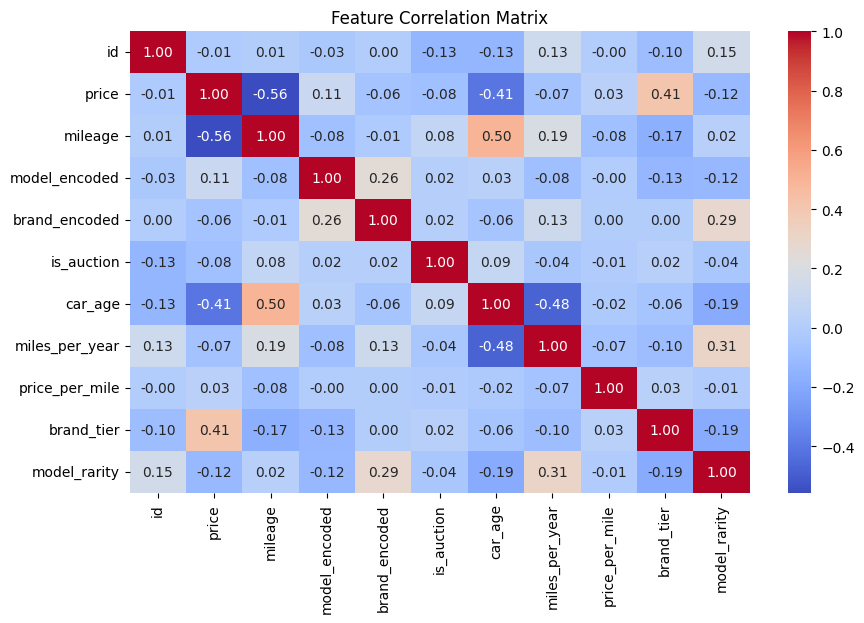

In [16]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### The "Mileage Penalty" (Justifies Price vs. Mileage: -0.56)
- This chart visually proves that as mileage increases, the price drops reliably. The red regression line helps confirm this negative trend, validating why mileage is likely strongest predictor.

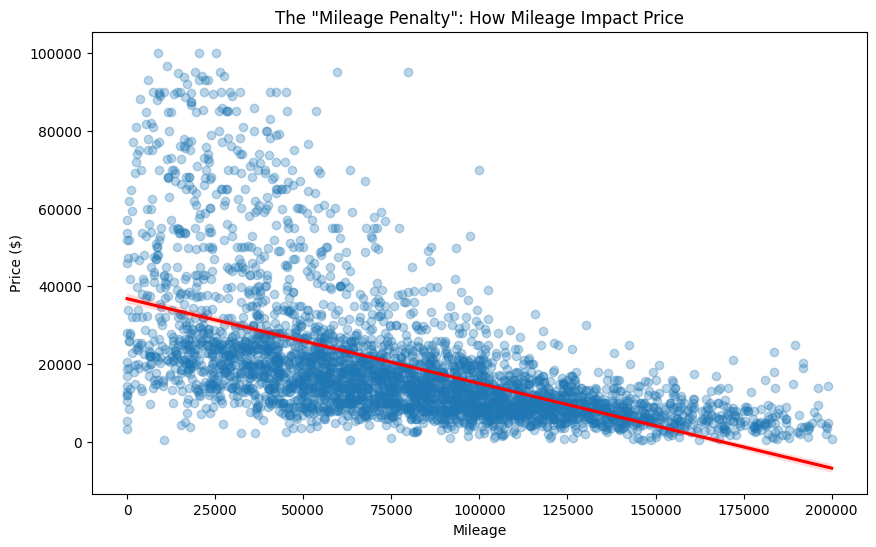

In [17]:
plt.figure(figsize=(10, 6))
sns.regplot(x='mileage', y='price', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('The "Mileage Penalty": How Mileage Impact Price')
plt.xlabel('Mileage')
plt.ylabel('Price ($)')
plt.show()

### The "Luxury Premium" (Justifies Price vs. Brand Tier: +0.41)
- This chart justifies the engineering of the brand_tier feature. 
- It demonstrates that cars in Tier 3 (Luxury) have a significantly higher price floor and ceiling compared to Tier 1 (Budget) cars.
- Confirming that brand positioning is a distinct driver of value.

C:\Users\Mujahid\AppData\Local\Temp\ipykernel_18692\81797849.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='brand_tier', y='price', data=df, palette='viridis')


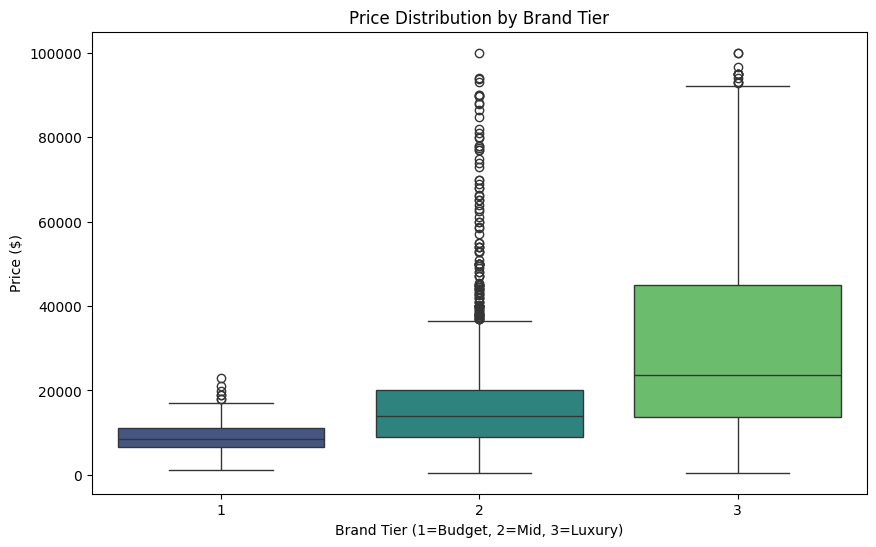

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='brand_tier', y='price', data=df, palette='viridis')
plt.title('Price Distribution by Brand Tier')
plt.xlabel('Brand Tier (1=Budget, 2=Mid, 3=Luxury)')
plt.ylabel('Price ($)')
plt.show()

### The Depreciation Curve (Justifies Price vs. Age: -0.41)
- This visualization validates the impact of car_age on value. It reveals the non-linear nature of depreciation.
- A steep drop in value during the first few years (0–5), followed by a flattening of the curve as cars get older. 
- Coloring by brand_tier highlights that while all cars depreciate, luxury cars (Tier 3) often maintain a higher price point throughout their lifespan compared to budget models.

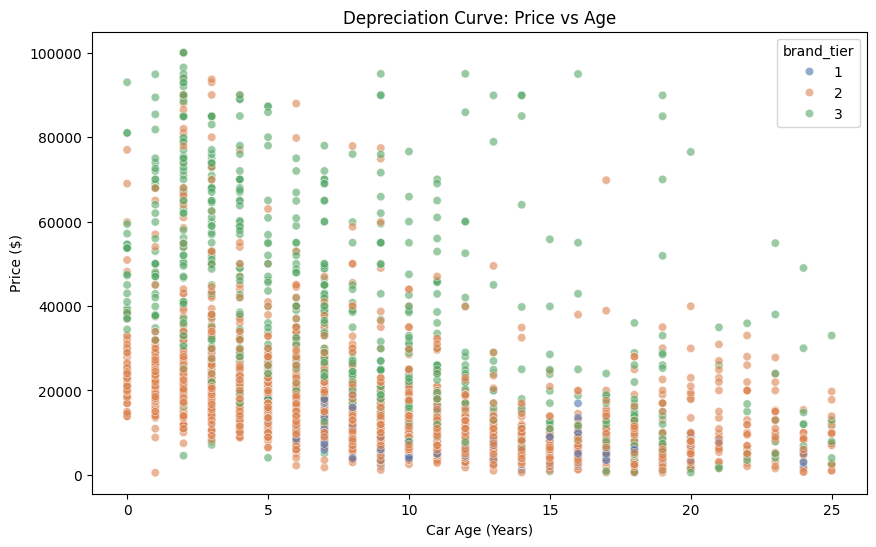

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='car_age', y='price', hue='brand_tier', data=df, palette='deep', alpha=0.6)
plt.title('Depreciation Curve: Price vs Age')
plt.xlabel('Car Age (Years)')
plt.ylabel('Price ($)')
plt.show()

# Phase 3: Data Cleaning & Feature Engineering Summary

### 1. The Challenge: "Dirty Data"
Web scraping yields unstructured and messy data. Raw listing titles like *"2015 Toyota Camry!!! 74k Miles L@@K"* are impossible for Machine Learning models to understand directly.
* **Goal:** Transform raw text strings into structured, numerical features.
* **Input:** `ebay_cars.db` (Thousands of messy rows).
* **Output:** `cleaned_car_data.csv` & `cleaned_listings` table in ebay_cars.db (Clean & encoded).

### 2. Data Cleaning Pipeline (Regex Magic)
I implemented robust custom functions using **Regular Expressions (Regex)** to extract valid numbers from mixed text:
* **Mileage Standardization:** Built logic to handle suffixes ("74k" $\rightarrow$ 74,000) and removed text noise.
* **Year Extraction:** Used regex `\b(19|20)\d{2}\b` to surgically extract valid 4-digit years from chaotic titles.

### 3. Advanced Feature Engineering (Creating Intelligence)
I went beyond simple extraction and engineered **domain-specific features** to give the model "market intuition":

* **Brand Tier (The "Prestige" Factor):**
    * *Logic:* Mapped brands to distinct categories (1=Economy, 2=Mid-Range, 3=Luxury).
    * *Impact:* Captured the "Luxury Premium," proving a +0.41 correlation with price.
* **Miles Per Year (Usage Intensity):**
    * *Logic:* `Mileage / Car Age`.
    * *Impact:* Distinguishes between a "high-mileage new car" (abused) and a "high-mileage old car" (normal usage).
* **Model Rarity (Supply & Demand):**
    * *Logic:* Calculated frequency scores for every car model.
    * *Impact:* Helps the model understand that a rare "Supra" commands a different price than a common "Corolla."
* **Car Age:** Calculated `2025 - Year` to measure depreciation directly.

### 4. Text Processing Strategy
The hardest part was extracting a clean **"Model Name"** from chaotic titles to enable the Rarity calculation.
* **Noise Removal:** Stripped sales buzzwords (*"nice"*, *"loaded"*, *"warranty"*).
* **The "Ghost Car" Fallback:** If aggressive cleaning removed the entire title, I renamed with "Brand" + "Year" to make it a better title rather than just random words. Although, the count was very less.

### 5. Leakage Prevention & Encoding
To prepare for modeling, I made critical decisions to ensure the model learns correctly without "cheating":
* **Price_per_miles:** I I will remove it from model learning so it doesn't take as decisive parameter to predict price. It was only to show whether a car is driven more than an average car.
* **Redundancy Removal:** I dropped the `Year` column from training because it is a perfect duplicate of `Car_Age`.
* **Encoding:** Applied **Label Encoding** to convert categorical text (Brand/Model) into numerical IDs.

### 6. Key Insights & Visual Validation
Before modeling, I validated the data through visualization:
* **The "Mileage Penalty":** Confirmed a strong linear drop in price as mileage increases (-0.56 Correlation).
* **The Depreciation Curve:** Visualized an "L-shaped" value drop, showing rapid depreciation in the first 5 years.
* **The Luxury Floor:** Validated that Tier 3 brands maintain a higher minimum price point throughout their lifecycle.

### Conclusion
I successfully transformed messy, human-readable text into a structured, sophisticated dataset. The data is now fully numerical and contains **engineered intelligence** (Tier, Rarity, Usage) ready for high-performance modeling.